In [1]:
#!pip install synapseclient

In [2]:
#!pip install synapseutils

In [3]:
#  import synapseclient 
#  import synapseutils 
 
#  syn = synapseclient.Synapse() 
#  syn.login('finamintoastcrunch','1Hjldria!') 
#  files = synapseutils.syncFromSynapse(syn, ' syn2825306 ') 

# Import Libraries

In [4]:
import tensorflow as tf
from tensorflow import keras
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
 

from tensorflow.keras.layers import*
from keras.utils.vis_utils import plot_model
import tensorflow.keras.backend as Ks
# from keras.layers import Input
# from keras.layers import Dense
# from keras.layers import Conv1D
# from keras.layers import Conv1DTranspose
# from keras.layers import Flatten, Reshape

import os
from glob import glob
from tqdm import tqdm
from tensorflow.keras import losses
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from keras_visualizer import visualizer 
import visualkeras

In [5]:
tf.config.list_physical_devices(
    device_type=None
)
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
tf.executing_eagerly()

True

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [9]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


# Set Constants and Load Dataset

In [10]:
NUM_PARENTS = 334
NUM_TARGETS = 4510
NUM_TIME_STEPS = 805
NUM_REPLICATES = 1 

In [11]:

# matrix_path = "regulator-gene-matrix.csv"
# data_path_syn = r"C:\Users\Fin Amin\Desktop\StemCellResearch\Fin_preProcessed\synData"
# data_path_inter =  r"C:\Users\Fin Amin\Desktop\StemCellResearch\Fin_preProcessed\interpolatedOnly"
# data_path_og_exp1 = r"C:\Users\Fin Amin\Desktop\StemCellResearch\Fin_preProcessed\datasets\exp1"
# data_path_testSet = r"C:\Users\Fin Amin\Desktop\StemCellResearch\testSetFixed"
# data_path_petal = r"C:\Users\Fin Amin\Desktop\StemCellResearch\petal_len.xlsx"

In [12]:
#dirty_RGM = r'Regulations_Control_Altona.csv' #For dream5, we dont have an RGM so we have to do things blindly... I think?
dirty_regulations = r'net3_expression_data.tsv'

In [13]:
#dirtyRGM = pd.read_csv(dirty_RGM,  index_col = 0, )#on_bad_lines='skip')
dirtyReg = pd.read_table(dirty_regulations,  index_col = 0,)# on_bad_lines='skip')
dirtyReg = dirtyReg.select_dtypes(include=np.number)
dirtyReg = dirtyReg.to_numpy()
dirtyReg.shape

(805, 4510)

In [14]:
dirtyReg

array([[ 9.3293,  9.5997,  6.9998, ...,  6.4199,  7.3635,  9.9146],
       [ 9.2212,  9.4961,  6.8697, ...,  6.7346,  7.3835,  8.6026],
       [ 8.631 , 10.273 ,  7.0817, ...,  6.6771,  8.3439,  8.6646],
       ...,
       [ 8.0524, 10.778 ,  6.607 , ...,  7.573 ,  6.8951,  8.9295],
       [ 8.3784, 11.008 ,  6.7755, ...,  6.5779,  7.2277,  8.7563],
       [ 8.1178, 11.274 ,  6.5021, ...,  7.3586,  6.9848,  9.0106]])

In [15]:
#TODO: Fix this. it puts nans where it should not. 

def fix_dataset(dirtyR):
    shape = dirtyR.shape
    # dataset = np.zeros(shape=(dirtyR.shape))

    tmp = dirtyR.flatten()
    regScaled = StandardScaler().fit_transform(tmp.reshape((-1,1)))
    regScaled = MinMaxScaler().fit_transform(tmp.reshape((-1,1)))
    ret = regScaled.reshape(shape)
    
    return ret

dataset = fix_dataset(dirtyR=dirtyReg)
dataset.shape

(805, 4510)

In [16]:
#only one dataset so we set bean and etc all to the same 
ecoli_Intensities = np.array([dataset])
validation = np.array([dataset])
print(ecoli_Intensities.shape, validation.shape)

(1, 805, 4510) (1, 805, 4510)


In [17]:
#the third replicate is trash. we will not use it. 
# df(dataset[3]).head(11) 

In [18]:
# regulator_gene_matrix = np.load("soyBeanRGM.npy")
# regulator_gene_matrix = regulator_gene_matrix.astype('float32')
# regulator_gene_matrix.shape

# Super Parent Matrix + Custom Loss

In [19]:
#first 333 genes are parents
regulator_gene_matrix = np.ones((NUM_TARGETS,NUM_TARGETS), dtype='float32')
regulator_gene_matrix[NUM_PARENTS:] = 0

superParent = np.ones((NUM_TARGETS, NUM_TARGETS), dtype = 'float32')
superParent[NUM_PARENTS:] = 0

In [20]:
parentIndex = np.arange(stop=NUM_PARENTS)
parentIndex = tf.convert_to_tensor(parentIndex)
parent_idx = parentIndex.numpy()

In [21]:
# superParent = regulator_gene_matrix.copy() #init the super parent with the ordinary RGM, and do forward passes with super parent
#print(superParent.shape)

# ones = np.ones((NUM_TARGETS))
# parentIndex = []
# not_parentIndex = []
# for i in range(len(regulator_gene_matrix)):
#     if (np.isin(regulator_gene_matrix[i], [1])).any():
#         #print(i)
#         superParent[i] = ones 
#         parentIndex.append(i)
#     else:
#         not_parentIndex.append(i)

# parentIndex = np.array(parentIndex)
# parentIndex = tf.convert_to_tensor(parentIndex)
# parent_idx = parentIndex.numpy()
# not_parentIndex = np.array(not_parentIndex)
# not_parentIndex = tf.convert_to_tensor(not_parentIndex)
print("shape of parent index", parentIndex.shape)

def ignore_noParent_MSE_old(y_true, y_pred): 
    l = tf.keras.losses.MeanSquaredError()
    y_true_pruned = tf.gather(y_true,parentIndex, axis =2) 
    #print(y_true_pruned.shape
    y_pred_pruned = tf.gather(y_pred, parentIndex, axis =2)   
    return l(y_true_pruned, y_pred_pruned)

#this will not work if the entire dataset is -1 (degenerate), or has only one actual value (also degen)
def ignore_noParent_MSE(y_true, y_pred): 
    l = tf.keras.losses.MeanSquaredError()
   # print(y_true.shape) #(None, 44, 372)

    #get the parents and flatten them
    y_true_pruned = tf.gather(y_true, parentIndex, axis = 2) #axis 2 because batch, time, gene
    y_true_pruned = tf.reshape(y_true_pruned, shape=([tf.size(y_true_pruned)] ) )

   # print(y_true_pruned.shape)
   # print("tf size", tf.size(y_true_pruned))

    y_pred_pruned = tf.gather(y_pred, parentIndex, axis = 2) 
    y_pred_pruned = tf.reshape(y_pred_pruned, shape=([tf.size(y_pred_pruned)]) )

    #get the index of the parents which are not -1
    y_true_posID = tf.where(y_true_pruned >= 0) #gets args
    y_true_posID = tf.squeeze(y_true_posID)
    #get the idx of all the -1s 
    y_true_negID = tf.where(y_true_pruned < 0) 
    y_true_negID = tf.squeeze(y_true_negID)

    #get all the -1s in the parents 
    y_true_neg = tf.gather(y_true_pruned, y_true_negID) #get all the -1s in y_true
    y_pred_neg = tf.gather(y_pred_pruned, y_true_negID) #get the corresponding values for y_pred

    #get the indexes where pred should be -1 but is not. get the corresponding index for ytrue
    y_shouldBeNegButIsntID = tf.where(y_pred_neg >= 0)  
    y_shouldBeNegButIsntID = tf.squeeze(y_shouldBeNegButIsntID) #get the idx which should be -1 for prediction but are not
    y_true_wrong = tf.gather(y_true_pruned, y_shouldBeNegButIsntID) #get the same corresponding values from ytrue
    y_shouldBeNegButIsnt = tf.gather(y_pred_pruned, y_shouldBeNegButIsntID) #this has all the wrongly predicted values which should be -1 but are not

    y_true_pos = tf.gather(y_true_pruned, y_true_posID)
    y_pred_pos = tf.gather(y_pred_pruned, y_true_posID)

    if tf.size(y_shouldBeNegButIsnt) == 0: #we can not concatenate if the size is 0. 
        return l(y_true_pos, y_pred_pos)

    if tf.size(y_shouldBeNegButIsnt) == 1: #dim goes away if size = 1. 
        y_shouldBeNegButIsnt = tf.expand_dims(y_shouldBeNegButIsnt, axis = 0) #should all be flattened
        y_true_wrong = tf.expand_dims(y_true_wrong, axis=0)

    #print("y_pred", (y_pred_pos), "y_true", (y_shouldBeNegButIsnt))
    try:
        y_pred_total = tf.concat([y_pred_pos, y_shouldBeNegButIsnt], axis = 0) #concatenate for total mse
        y_true_total = tf.concat([y_true_pos, y_true_wrong], axis = 0)
    except Exception as e:
        print(y_pred_pos.shape, y_shouldBeNegButIsnt.shape, tf.size(y_shouldBeNegButIsnt))
        return l(y_true_pos, y_pred_pos)

    return l(y_true_total, y_pred_total)

shape of parent index (334,)


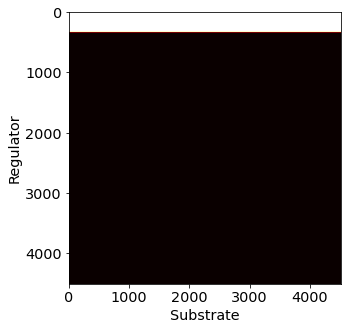

In [22]:
plt.imshow(superParent, cmap='hot');
plt.xlabel("Substrate");
plt.ylabel("Regulator");

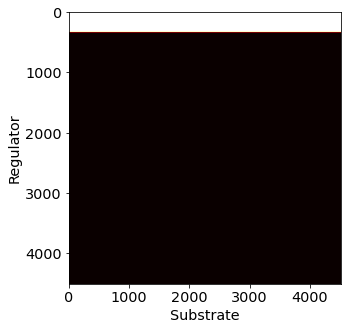

In [23]:
plt.imshow(regulator_gene_matrix, cmap='hot');
plt.xlabel("Substrate");
plt.ylabel("Regulator");

# Ordinary Auto Encoder

In [24]:
class EncoderLinear(tf.keras.layers.Layer):
    def __init__(self, rgm, input_dim=32, units=32):
        super(EncoderLinear, self).__init__()
        self.rgm = rgm
        
        def init_weights(shape, dtype="float32"):

            w_init = tf.random_normal_initializer()(shape=shape, dtype=dtype) * tf.convert_to_tensor(self.rgm, dtype=dtype)

            return w_init
        

        self.w = tf.Variable(
            initial_value=init_weights(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
        X = inputs
        return tf.matmul(X, tf.multiply(self.rgm, self.w))
    #tf.matmul(inputs, self.w)

In [25]:
class DecoderLinear(tf.keras.layers.Layer):
    def __init__(self, rgm, input_dim=32, units=32):
        super(DecoderLinear, self).__init__()
        self.rgm = rgm

        def init_weights(shape, dtype="float32"):

            w_init = tf.random_normal_initializer()(shape=shape, dtype=dtype) * tf.transpose(tf.convert_to_tensor(self.rgm, dtype=dtype))

            return w_init
    
        
        self.w = tf.Variable(
            initial_value=init_weights(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
        X = inputs
        #return tf.matmul(X, tf.multiply((self.rgm), self.w))
        X = tf.matmul(X, tf.multiply(tf.transpose(self.rgm), self.w)) 
        #return tf.matmul(inputs, self.w)
        # v = tf.zeros_like(X)
        # u = tf.ones_like(X)
        # u = tf.math.scalar_mul(-3.0, u)
        
        return X#tf.where(tf.math.less(X, v), u, X) #where X is less than 0, return -1 
        
        

In [26]:
def encoder(parent_child_biological_association, num_hidden_units=21):
    '''
    Encoder structure
    '''
    '''
    The data is time-series. Therefore, CNN to learn the temporal relationship between 
    the intensities for each gene.
    '''
    en_conv = Conv1D(32, 3, activation = "relu")(parent_child_biological_association) # 6*NUM_TARGETS Conv1D(32, 3, activation = "relu")(parent_child_biological_association)
    en_dense = Flatten()(en_conv)
    phenotype = Dense(num_hidden_units)(en_dense)
    return phenotype

def decoder(X, num_protein_gene, time_steps):
    '''
    Decoder structure
    '''
    de_dense = Dense(128)(X)#Dense(128)(X)
    de_dense = Reshape((1, 128))(de_dense) #tf.reshape(de_dense, (self.batch_size,1,128))
    de_deconv = Conv1DTranspose(num_protein_gene, time_steps, activation = "relu")(de_dense) #used to be transpose
    #de_deconv = Conv1D(num_protein_gene, time_steps, activation = "relu")(de_dense) 
    # gene_reconstruction = self.decoder_biological_operation(de_deconv)
    return de_deconv

def model(rgm, num_protein_gene, time_steps, num_kinase_regulators, num_hidden_units = 32):
    inp = Input(shape=(time_steps, num_kinase_regulators))
    x = EncoderLinear(rgm, NUM_TARGETS, NUM_TARGETS)(inp)
    enc = encoder(x, num_hidden_units)
    dec = decoder(enc, num_protein_gene, time_steps)
    out = DecoderLinear(rgm, NUM_TARGETS, NUM_TARGETS)(dec)

    _model = tf.keras.Model(inputs=inp, outputs=out)

    return _model

In [27]:
# ordinaryAE = model(regulator_gene_matrix, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS)
# ordinaryAE.compile(optimizer='adam', loss=ignore_noParent_MSE)

In [28]:
# o = ordinaryAE.fit(ecoli_Intensities, ecoli_Intensities, epochs=200, verbose = True, validation_data=(validation, validation))
#print(o.history['loss'][-1]) #the final loss 

# Super Parent AutoEncoder

In [29]:
class EncoderLinearSuperParent(tf.keras.layers.Layer):
    def __init__(self, rgm, oldrgm, input_dim=32, units=32):
        super(EncoderLinearSuperParent, self).__init__()
        self.rgm = rgm
        self.OGrgm = oldrgm
        
        def init_weights(shape, dtype="float32"):

            w_init = tf.random_normal_initializer()(shape=shape, dtype=dtype) * tf.convert_to_tensor(self.OGrgm, dtype=dtype)

            return w_init
        

        self.w = tf.Variable(
            initial_value=init_weights(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
        X = inputs
        return tf.matmul(X, tf.multiply(self.rgm, self.w))


class DecoderLinearSuperParent(tf.keras.layers.Layer):
    def __init__(self, rgm, oldrgm, input_dim=32, units=32):
        super(DecoderLinearSuperParent, self).__init__()
        self.rgm = rgm
        self.OGrgm = oldrgm

        def init_weights(shape, dtype="float32"):

            w_init = tf.random_normal_initializer()(shape=shape, dtype=dtype) * tf.transpose(tf.convert_to_tensor(self.rgm, dtype=dtype))

            return w_init
    
        
        self.w = tf.Variable(
            initial_value=init_weights(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
        X = inputs
        X = tf.matmul(X, tf.multiply(tf.transpose(self.rgm), self.w)) 
        return X
        
        
def encoder(parent_child_biological_association, num_hidden_units=21):
    '''
    Encoder structure
    '''
    '''
    The data is time-series. Therefore, CNN to learn the temporal relationship between 
    the intensities for each gene.
    '''
    en_conv = Conv1D(32, 3, activation = "relu")(parent_child_biological_association) # 6*NUM_TARGETS
    en_dense = Flatten()(en_conv)
    phenotype = Dense(num_hidden_units)(en_dense)
    return phenotype

def decoder(X, num_protein_gene, time_steps):
    '''
    Decoder structure
    '''
    de_dense = Dense(128)(X)
    de_dense = Reshape((1, 128))(de_dense) #tf.reshape(de_dense, (self.batch_size,1,128))
    de_deconv = Conv1DTranspose(num_protein_gene, time_steps, activation = "relu")(de_dense) #used to be transpose
    #de_deconv = Conv1D(num_protein_gene, time_steps, activation = "relu")(de_dense) 
    # gene_reconstruction = self.decoder_biological_operation(de_deconv)
    return de_deconv

def modelSuperParent(rgm, oldRGM, num_protein_gene, time_steps, num_kinase_regulators, num_hidden_units = 21): #rgm is set to superparent, oldrgm is original rgm unmodified
    inp = Input(shape=(time_steps, num_kinase_regulators))
    x = EncoderLinearSuperParent(rgm, oldRGM, NUM_TARGETS, NUM_TARGETS)(inp)
    enc = encoder(x, num_hidden_units)
    dec = decoder(enc, num_protein_gene, time_steps)
    out = DecoderLinearSuperParent(rgm, oldRGM, NUM_TARGETS, NUM_TARGETS)(dec)

    _model = tf.keras.Model(inputs=inp, outputs=out)

    return _model

In [30]:
def modelSuperParentSequential(rgm, oldRGM, num_protein_gene, time_steps, num_kinase_regulators, num_hidden_units = 32): #rgm is set to superparent, oldrgm is original rgm unmodified
    m = tf.keras.Sequential()
    inp = Input(shape=(time_steps, num_kinase_regulators))
    x = EncoderLinearSuperParent(rgm, oldRGM, NUM_TARGETS, NUM_TARGETS)(inp)
    enc = encoder(x, num_hidden_units)
    dec = decoder(enc, num_protein_gene, time_steps)
    out = DecoderLinearSuperParent(rgm, oldRGM, NUM_TARGETS, NUM_TARGETS)(dec)

    _model = tf.keras.Model(inputs=inp, outputs=out)

    return _model

In [31]:
# del ordinaryAE #to fix OOM error

In [32]:
# looseParent = modelSuperParent(superParent, regulator_gene_matrix, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, 32)
# looseParent.compile(optimizer='adam', loss=ignore_noParent_MSE)
# o = looseParent.fit(ecoli_Intensities, ecoli_Intensities, epochs=200, verbose = True,  validation_data=(validation, validation))
#print(o.history['loss'][-1]) #the final loss 

In [33]:
#3.2040e-04 - val_loss: 3.1109e-04 <ordinary

#loss: 1.8528e-10 - val_loss: 1.7311e-10 <dense

# DenseNetAutoEncoder

In [34]:
'''
a second copy of the layers which will be modified to be a denseNET auto encoder
'''

class DAE_Encoder_MASK(tf.keras.layers.Layer): 
    def __init__(self, rgm, oldrgm, input_dim=32, units=32):
        super(DAE_Encoder_MASK, self).__init__()
        self.rgm = rgm
        self.oldrgm = oldrgm
        
        def init_weights(shape, dtype="float32"):

            w_init = tf.random_normal_initializer()(shape=shape, dtype=dtype) * tf.convert_to_tensor(self.oldrgm, dtype=dtype)

            return w_init
        

        self.w = tf.Variable(
            initial_value=init_weights(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
        X = inputs
        return tf.matmul(X, tf.multiply(self.rgm, self.w))
    #tf.matmul(inputs, self.w)

    def get_config(self):
        config = super().get_config()
        config.update({
            "rgm": self.rgm,
            "oldrgm": self.oldrgm,
            'input_dim': 32,
            'units' : 32
        })

class DAE_Decoder_MASK(tf.keras.layers.Layer):
    def __init__(self, rgm, oldrgm, input_dim=32, units=32):
        super(DAE_Decoder_MASK, self).__init__()
        self.rgm = rgm
        self.oldrgm = oldrgm

        def init_weights(shape, dtype="float32"):

            w_init = tf.random_normal_initializer()(shape=shape, dtype=dtype) * tf.transpose(tf.convert_to_tensor(self.oldrgm, dtype=dtype))

            return w_init

        self.w = tf.Variable(
            initial_value=init_weights(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
        X = inputs
        return tf.matmul(X, tf.multiply(tf.transpose(self.rgm), self.w)) #used to have a transpose


    def get_config(self):
        config = super().get_config()
        config.update({
            "rgm": self.rgm,
            "oldrgm": self.oldrgm,
            'input_dim': 32,
            'units' : 32
        })
        

def denseencoder2(parent_child_biological_association, inp, num_hidden_units=21):
    '''
    Encoder structure
    '''
    '''
    The data is time-series. Therefore, CNN to learn the temporal relationship between 
    the intensities for each gene.
    '''
    en_conv = Conv1D(32, 5, activation = "tanh")(parent_child_biological_association) # Conv1D(NUM_TARGETS, NUM_TIME_STEPS, activation = "tanh")(parent_child_biological_association)6*NUM_TARGETS
    en_dense = Flatten()(en_conv)
    inp = Flatten()(inp)
    d = Concatenate()([en_dense, inp]) #dense layer
    phenotype = Dense(num_hidden_units, activation="tanh")(d)
    return phenotype

def densedecoder2(X, num_protein_gene, time_steps):
    '''
    Decoder structure
    '''
    de_dense = Dense(16, activation = 'tanh')(X)
    de_dense = Reshape((1, 16))(de_dense) #tf.reshape(de_dense, (self.batch_size,1,128))
    de_deconv = Conv1DTranspose(num_protein_gene, time_steps, activation = "tanh")(de_dense) #used to be transpose
    #de_deconv = Conv1D(num_protein_gene, time_steps, activation = "relu")(de_dense) 
    # gene_reconstruction = self.decoder_biological_operation(de_deconv)
    return de_deconv

def modelDense2(rgm, oldrgm, num_protein_gene, time_steps, num_kinase_regulators, num_hidden_units = 21):
    inp = Input(shape=(time_steps, num_kinase_regulators))
    x = DAE_Encoder_MASK(rgm, oldrgm, NUM_TARGETS, NUM_TARGETS)(inp)
    #x = EncoderLinear2(x)
    enc = denseencoder2(x, inp, num_hidden_units)
    dec = densedecoder2(enc, num_protein_gene, time_steps)
    out = DAE_Decoder_MASK(rgm, oldrgm, NUM_TARGETS, NUM_TARGETS)(dec)

    _model = tf.keras.Model(inputs=inp, outputs=out)

    return _model

In [35]:
ecoli_IntensitiesMask = np.matmul(ecoli_Intensities, superParent)

In [36]:
ecoli_IntensitiesMask.shape

(1, 805, 4510)

In [37]:
dense = modelDense2(superParent, regulator_gene_matrix, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, 16)
dense.compile(optimizer='adam', loss=ignore_noParent_MSE)
# dense.fit(ecoli_IntensitiesMask, ecoli_Intensities, epochs=50,  verbose=True, validation_data=(validation, validation))

In [38]:
dense.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 805, 4510)]  0           []                               
                                                                                                  
 dae__encoder_mask (DAE_Encoder  (None, 805, 4510)   20340100    ['input_1[0][0]']                
 _MASK)                                                                                           
                                                                                                  
 conv1d (Conv1D)                (None, 801, 32)      721632      ['dae__encoder_mask[0][0]']      
                                                                                                  
 flatten (Flatten)              (None, 25632)        0           ['conv1d[0][0]']             

In [39]:
# for l in dense.layers:
#     l._name = ''

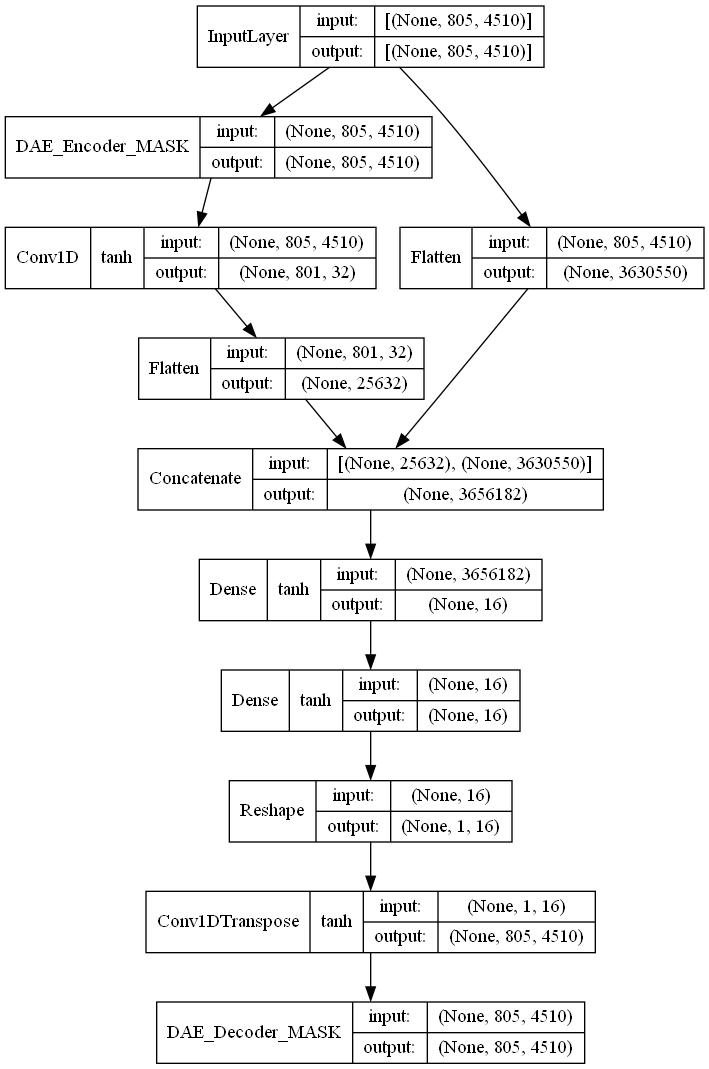

In [41]:
plot_model(dense, show_shapes= True, show_layer_activations=True, show_layer_names=False)

In [45]:
def m2tex(model):
    stringlist = []
    model.summary(line_length=100, print_fn=lambda x: stringlist.append(x))
    del stringlist[1:-4:2]
    del stringlist[-1]
    for ix in range(1,len(stringlist)-3):
        tmp = stringlist[ix]
        stringlist[ix] = tmp[0:31]+"& "+tmp[31:59]+"& "+tmp[59:]+"\\\\ \hline"
    stringlist[0] = "Model: test \\\\ \hline"
    stringlist[1] = stringlist[1]+" \hline"
    stringlist[-4] = stringlist[-4]+" \hline"
    stringlist[-3] = stringlist[-3]+" \\\\"
    stringlist[-2] = stringlist[-2]+" \\\\"
    stringlist[-1] = stringlist[-1]+" \\\\ \hline"
    prefix = ["\\begin{table}[]", "\\begin{tabular}{lll}"]
    suffix = ["\end{tabular}", "\caption{Model summary for test.}", "\label{tab:model-summary}" , "\end{table}"]
    stringlist = prefix + stringlist + suffix 
    out_str = " \n".join(stringlist)
    out_str = out_str.replace("_", "\_")
    out_str = out_str.replace("#", "\#")
    print(out_str)

In [46]:
m2tex(dense)

\begin{table}[] 
\begin{tabular}{lll} 
Model: test \\ \hline 
 Layer (type)                  &   Output Shape          Para& m \#     Connected to                     \\ \hline \hline 
 Masked by M' (InputLayer)     &   [(None, 805, 4510)]   0   &         []                               \\ \hline 
 dae\_\_encoder\_mask (DAE\_Encoder& \_  (None, 805, 4510)    2034& 0100    ["Masked by M'[0][0]"]           \\ \hline 
                               &                             &                                          \\ \hline 
                               &                             &                                          \\ \hline 
                               &                             &                                          \\ \hline 
                               &                             &                                          \\ \hline 
                               &                             &          'flatten\_1[0][0]']              \\ \hline 
 den

In [74]:
# tf.keras.backend.clear_session()
# del dense

# Reconstruction

In [75]:
# o = dense.predict(validation)
# o.shape

In [76]:
# r = pd.DataFrame(np.squeeze(o))
# v = pd.DataFrame(np.squeeze(validation))

In [77]:
# r[parent_idx].head(NUM_TIME_STEPS)

In [78]:
# v[parent_idx].head(NUM_TIME_STEPS)

In [79]:
# ignore_noParent_MSE(validation, o)

# Latent Space Size Experiment

In [80]:
# N = 40
# hidden = np.arange(10,NUM_PARENTS, 20) #range(1,32)
# lossMatrix = []
# for i in tqdm(range(N), colour='red'):
    
#     losses = []
#     for value in (hidden):
#         dense = modelDense2(superParent, regulator_gene_matrix, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, value)
#         dense.compile(optimizer='adam', loss=ignore_noParent_MSE)
#         dense.fit(ecoli_Intensities, ecoli_Intensities, epochs=30,  verbose=0)
#         test_hat = dense(validation) #, verbose = 0)
#         loss = ignore_noParent_MSE(validation, test_hat)
#         losses.append(loss)
#         tf.keras.backend.clear_session()
#         del dense
#     lossMatrix.append(losses)
# lossMatrix = np.array(lossMatrix)

#run 100 times 

In [81]:
# avgMSE = np.average(lossMatrix, axis = 0)
# plt.plot(hidden, avgMSE);
# plt.xlabel("Latent Space Size");
# plt.ylabel("MSE");
# plt.title("MSE of the AutoEncoder with Respect to the Latent Space Size");

In [82]:
# lm = pd.DataFrame(lossMatrix)
# lm.to_csv("lossmatrix4lisaDREAM5.csv")

In [83]:
# temp = pd.read_csv("lossmatrix4lisaDREAM5.csv").to_numpy()
# print(temp.shape)
# avgMSE = np.average(lossMatrix, axis=0)

In [84]:
# plt.plot(hidden, avgMSE)

# Lazy Kernels

In [85]:
def do_lazy_train(epochs=30, hidden = 24):

    '''trains the auto encoder epoch by epoch and returns the weights of the first layer'''
    ep = epochs
    hidden = [hidden,] #range(1,32)
    lossMatrix = []
    lazy_weights = []
    dense = modelDense2(superParent, regulator_gene_matrix, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, num_hidden_units=32)
    dense.compile(optimizer=tf.keras.optimizers.Adam(), loss=ignore_noParent_MSE)

    #for i in tqdm(range(ep)):
    for i in range(ep):
        dense.fit(ecoli_Intensities, ecoli_Intensities, validation_data=(validation, validation), epochs=1,  verbose=0)
        lazy_weights.append(dense.get_weights()[0])
        test = dense(validation) #, verbose = 0)
        loss = ignore_noParent_MSE(validation, test)
        lossMatrix.append(loss)
        
    lossMatrix = np.array(lossMatrix) #loss matrix no longer returns anything 
    lazy_weights = np.array(lazy_weights)
    # print("lazy weights", lazy_weights.shape)

    return lossMatrix, lazy_weights #loss matrix no longer returns anything 

In [86]:
#https://proceedings.mlr.press/v162/rachwan22a/rachwan22a.pdf Winning the Lottery Ticket Ahead of Time:
def lazyKernelRegime(w, parent_idx=parent_idx):
    '''compute when each weight enters lazy kernel regime'''
    
    # print("wshape", w.shape)

    firstLayer = [] 
    for i in range(len(w)):
        firstLayer.append(w[i][parent_idx])

    fL = np.array(firstLayer)    
    # print("print fL", fL.shape, fL.dtype, fL[0], fL[1],)
    d0 = np.square(fL[1] - fL[0])
    # print("do", d0.shape, d0)
    
    kernelChange = []
    for i in range(1,len(fL)):
        dt = np.square(fL[i] - fL[0])
        dt_minus1 = np.square(fL[i-1] - fL[0])   
        d = np.abs(dt - dt_minus1)/d0                        #eq 11 from the paper
        kernelChange.append(d)
    
    kernelChange = np.moveaxis(kernelChange, 0, 2)
    # plt.plot(kernelChange[0][0]);
    # plt.title("$|\Delta W|$ vs Epoch")
    # plt.xlabel("Epoch")
    # plt.ylabel("$|\Delta W|$")

    return np.array(kernelChange)

In [87]:
def compute_distrib(change, t = .05, raw = False): #raw means return the unshaped indicies. 
    stop = []

    for parent in range(len(change)):
        for child in range(len(change[0])):
            try:
                stop.append(np.min(np.argwhere(change[parent][child] < t)))
            except ValueError:
                stop.append(len(change))
                # print(parent, child)
                # plt.plot(change[parent][child])
                # assert(False)

    
    stop = np.array(stop).flatten()
    # print("stop shape", stop.shape)
    # print(stop.shape)
    var = np.std(stop)
    # print(var)
    # assert(False)
    mean = np.average(stop)
    # print("mean, variance", mean, var)
    top_parents = np.argwhere(stop > (mean + var)) #get the parents which take more than 2 stds to stop training
    # print("top parents ", top_parents)
    # assert(False)
    top_parent_child = []
    for tp in top_parents:
        top_parent_child.append(np.unravel_index(tp, shape = (NUM_PARENTS, NUM_TARGETS)))

    if raw == False:
        plt.hist(stop)
        plt.xlabel("Epoch where regulator-target-weight began changing by at most "+ str(t));
        plt.ylabel("Number of parent-child-weights");
        plt.title("Histogram of weight stops");
        print("average stop: ", mean);

    if raw == True:
        return np.array(top_parents)

    return np.array(top_parent_child)

In [88]:
def lazyKernels(N=100):

    candidates = []
    final_w = []
    for i in tqdm(range(N)):
        lm, lazy_weights = do_lazy_train(epochs=60)
        # print("lm", lm)
        change = lazyKernelRegime(lazy_weights)
        # print("change",change)
        # assert(False)
        top_pr = np.squeeze(compute_distrib(change, t = 0.05, raw=True))
        candidates.append(top_pr)
        final_w.append(lazy_weights[-1]) #final w is used for magntiude calculations at the end
        tf.keras.backend.clear_session()
    
    final_w = np.array(final_w)
    firstLayer = []
    for i in range(len(final_w)):
        firstLayer.append(np.abs(final_w[i][parent_idx]))
    fw = np.array(firstLayer)
    #print(fw.shape)
    fw_avg = np.average(fw, axis = 0)
    #print(fw_avg.shape)
    
    candidates = np.hstack(candidates)
    candidates = candidates.reshape(candidates.size)
    #print(candidates.shape)

    # plt.hist(candidates, bins=np.arange(0, NUM_PARENTS*NUM_TARGETS))
    # plt.title("Parent-Child Regulator Histogram")
    # plt.xlabel("Parent-Child Weight")
    # plt.ylabel("Num-Times parent-child relationship trained for top 5% of time")
    return candidates, fw_avg



In [89]:
# for i in tqdm(range(8,50),colour='red'):
#     can, mag = lazyKernels(2)
#     s1 = "newCandidiate" + str(i) + ".npy"
#     s2 = "newMagnitude" + str(i) + ".npy"
#     np.save(s1, can) 

#     np.save(s2, mag) 

In [90]:
def process_saved():
    canArray = []
    magArray = []
    for i in range(50):
        s1 = r"allNP/newCandidiate" + str(i) + ".npy" #i mispelled candidate
        s2 = r"allNP/newMagnitude" + str(i) + ".npy"
        c = np.load(s1)
        m = np.load(s2)
        canArray.append(c)
        magArray.append(m)

    canArray = np.array(canArray)
    magArray = np.array(magArray)
    magArray = np.mean(magArray, axis=0)


    temp = []
    for c in canArray:
        for num in c:
            temp.append(num)
    k = np.array(temp)
    return k, magArray

In [91]:
can, mag = process_saved()

In [92]:
# canUp, magUp = can, mag = lazyKernels(1)

In [93]:
# can = canUp
# mag = magUp

In [94]:
mag.shape

(334, 4510)

In [242]:
def get_top_reg_targets(can, mag):
    
    pdf, bins = np.histogram(can, np.arange(0, NUM_PARENTS*NUM_TARGETS))
    pdf2d = np.zeros(shape = (NUM_PARENTS,NUM_TARGETS))

    for i in bins:
      idx2d = np.unravel_index(i, shape = (NUM_PARENTS, NUM_TARGETS))
      try:
        pdf2d[idx2d] = pdf[i]
      except IndexError:
        print(i, idx2d, len(pdf), len(bins))

    #plt.plot(pdf2d.flatten())
    # print(pdf2d.dtype)

    importance = np.multiply(pdf2d+1, mag )
    plt.plot(importance.flatten())
    print("mean", np.mean(importance.flatten()))
    print("std", np.std(importance.flatten()))

    # importance = np.multiply((np.square(pdf2d+1)), mag)
    # plt.plot(importance.flatten())
    return importance, pdf2d

1506339 (333, 4509) 1506339 1506340
mean 0.042829719681814045
std 0.011448945333079583


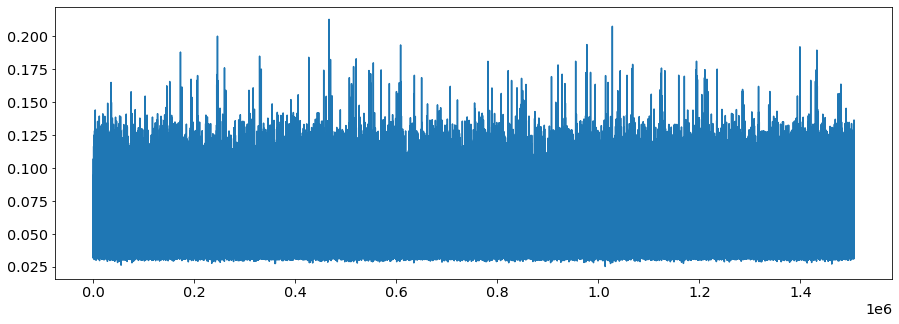

In [243]:
top, pdf = get_top_reg_targets(can, mag)

In [281]:
tff = top.flatten()
std = np.std(tff)

mu = np.mean(tff)
mu, std

(0.042829719681814045, 0.011448945333079583)

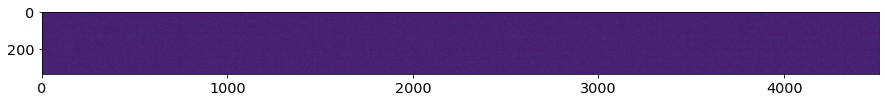

In [245]:
plt.imshow(top)

In [247]:
0.14/std

12.228200583288334

In [286]:
yout = np.where(top > mu + 3*std, 1, 0)
yout.dtype = 'int'

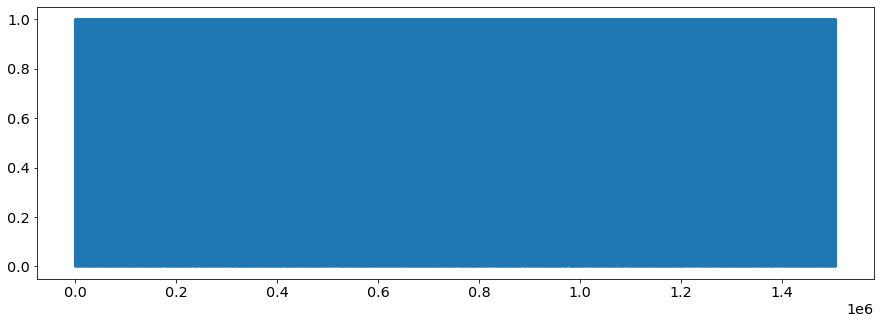

In [287]:
plt.plot(yout.flatten())

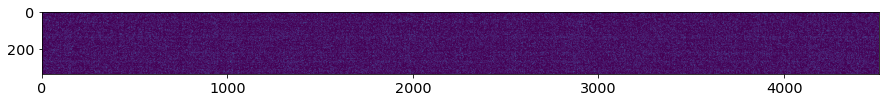

In [288]:
plt.imshow(yout)

In [289]:
np.count_nonzero(yout)

73929

In [290]:
flattop = top/np.max(top)
# flattop = pd.DataFrame(flattop)
# flattop.to_csv(r"allNP/Dream5_top_scaled_byMax.csv")

In [291]:
logtop = StandardScaler().fit_transform(top)
logtop = MinMaxScaler().fit_transform(logtop)

In [292]:
gold = pd.read_csv("DREAM5_NetworkInference_GoldStandard_Network3.csv", header=None)
gold.head(5)

,0,1,2
0,G92,G2,1
1,G232,G3,1
2,G55,G4,1
3,G56,G4,1
4,G268,G4,1


In [293]:
def keep_numeric(df):

    return df.applymap(lambda x: ''.join(filter(str.isdigit, str(x))) if isinstance(x, (int,float)) else ''.join(filter(str.isdigit, x)) )
gold = keep_numeric(gold)
goldnp = np.array(gold, dtype = 'int')
#subtract 1 from each index to match python index
goldnp[:,0] = goldnp[:,0] - 1
goldnp[:,1] = goldnp[:,1] - 1

goldIm = np.zeros(shape=(NUM_PARENTS,NUM_TARGETS))

for g in goldnp:
    reg = g[0]
    tar = g[1]
    connection = g[2]
    goldIm[reg][tar] = connection

In [294]:
magX = StandardScaler().fit_transform(mag.reshape((-1,1)))
magX = MinMaxScaler().fit_transform(magX.reshape((-1,1)))

In [295]:
print(goldnp.shape, goldnp.dtype)

(152280, 3) int32


In [296]:
np.average(mag)

0.039896842

In [297]:
y_true = goldIm.flatten()

In [309]:
roc_auc_score(y_true, yout.flatten())

0.5081437183874046

In [299]:
from sklearn.metrics import classification_report
print(classification_report(y_true, yout.flatten()))

              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97   1504274
         1.0       0.00      0.07      0.00      2066

    accuracy                           0.95   1506340
   macro avg       0.50      0.51      0.49   1506340
weighted avg       1.00      0.95      0.97   1506340



In [300]:
confusion_matrix(y_true, yout.flatten())

array([[1430480,   73794],
       [   1931,     135]], dtype=int64)

In [323]:
#AUPR score
from sklearn.metrics import auc, plot_precision_recall_curve
from sklearn.metrics import average_precision_score, precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_true, yout.flatten())
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)

0.034225825360488474


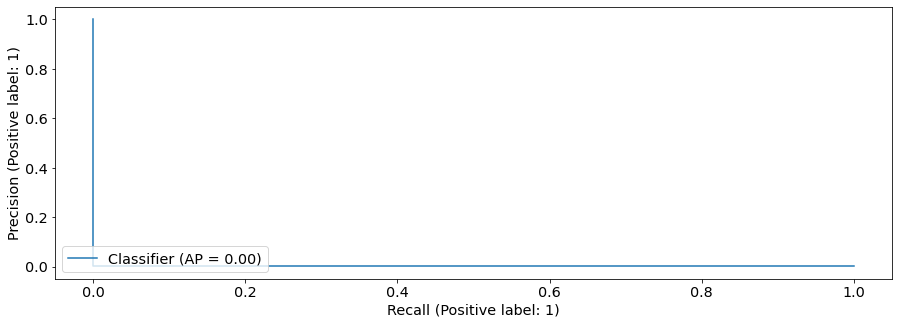

In [301]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_predictions(y_true, yout.flatten());

In [312]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_true, yout.flatten(), average='macro')

(0.5002389997982587, 0.5081437183874046, 0.48888349385319146, None)

In [319]:
roc_auc_score(goldIm.flatten(), flattop.flatten(), average='samples')


0.5127811638430617

In [236]:
confusion_matrix(y_true, np.rint( flattop.flatten()))

array([[1503252,    1022],
       [   2064,       2]], dtype=int64)

In [164]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_true, np.rint( flattop.flatten()))

array([[1503252,    1022],
       [   2064,       2]], dtype=int64)

In [150]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_true, np.rint( logtop.flatten()))

0.5081792525051056

In [151]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true, np.rint( logtop.flatten()) )

0.9546271094175286

In [306]:
np.count_nonzero(goldnp)/(NUM_PARENTS*NUM_TARGETS)

0.20355696589083475

In [130]:
np.count_nonzero(np.rint( flattop.flatten()) )

1024

In [132]:
np.count_nonzero(np.rint( logtop.flatten()) )

66824

In [116]:
goldIm.shape

(334, 4510)

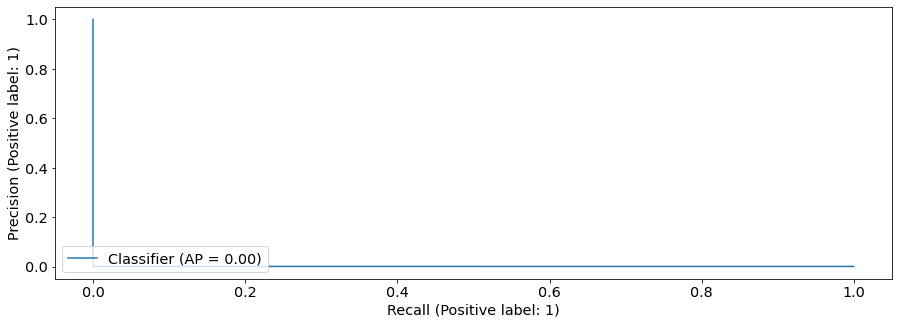

In [126]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_predictions(y_true, logtop.flatten()); #logtop.flatten()

In [71]:
######################################

In [72]:
can.shape

(92625,)

In [1]:
mag.shape

NameError: name 'mag' is not defined

In [435]:
NUM_PARENTS*NUM_TARGETS

1506340

In [436]:
can.shape

(424402,)

In [265]:
# np.save("candidate2.npy", can) 
# np.save("magnitude2.npy", mag) 

In [266]:
# plt.hist(can, bins=np.arange(0, NUM_PARENTS*NUM_TARGETS))

In [267]:
pdf, bins = np.histogram(can, bins=np.arange(NUM_PARENTS*NUM_TARGETS))
pdf

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [268]:
NUM_PARENTS*NUM_TARGETS

1506340

In [269]:
len(bins)

1506340

In [270]:
len(pdf)

1506339

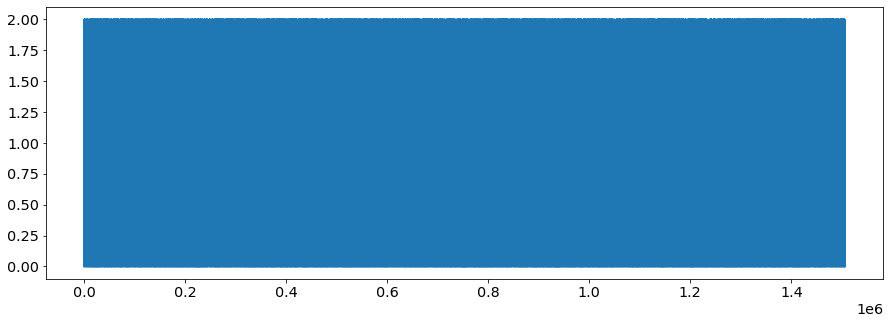

In [271]:
plt.plot(pdf)

In [272]:
np.count_nonzero(pdf)

149622

In [273]:
mag.shape

(334, 4510)

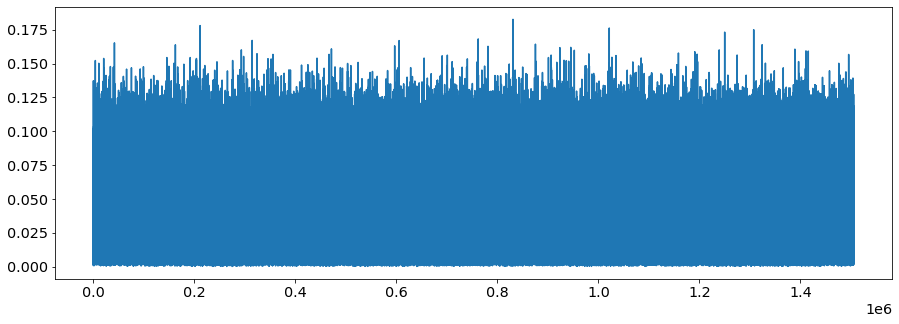

In [274]:
plt.plot(mag.flatten())

# Magnitudes After Training

In [275]:
NUM_PARENTS*NUM_TARGETS

1506340

In [276]:
NUM_TARGETS

4510

In [277]:
# np.unravel_index(NUM_PARENTS*NUM_TARGETS, shape = (NUM_PARENTS, NUM_TARGETS))

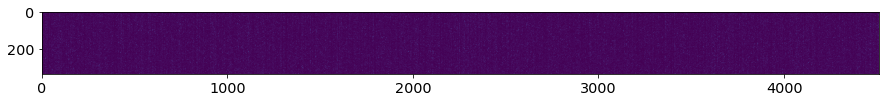

In [280]:
plt.imshow(pdf)

In [281]:
pdf

array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1., 16., 16.],
       [ 1.,  1.,  1., ...,  1., 16.,  1.],
       ...,
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1., 16., ...,  1.,  1., 16.],
       [ 1.,  1., 16., ...,  1.,  1.,  1.]])

In [282]:
top.dtype

dtype('float64')

In [283]:
np.average(top.flatten())


0.10321244745791318

In [284]:
np.std(top.flatten())

0.26090738692679816

In [285]:
flattop = top/np.max(top)
# flattop = pd.DataFrame(flattop)
# flattop.to_csv(r"allNP/Dream5_top_scaled_byMax.csv")

In [286]:
# flattop.head()

In [287]:
os.getcwd()

'c:\\Users\\Fin Amin\\Desktop\\StemCellResearch\\dream5EncoderDesktopFinal\\dream5Encoder'

In [288]:
t = pd.DataFrame(top)
# t.to_csv(r"allNP/Dream5_top_unscaled.csv")

In [289]:
logtop = StandardScaler().fit_transform(top)
logtop = MinMaxScaler().fit_transform(logtop)

In [290]:
tl = pd.DataFrame(logtop)
# tl.to_csv(r"allNP/Dream5_top_zscale_thenMinMax.csv")

In [293]:
np.histogram(top)

(array([1486511,   17023,    1146,     983,     434,     168,      54,
             17,       3,       1], dtype=int64),
 array([4.77068133e-05, 1.06644838e+00, 2.13284905e+00, 3.19924972e+00,
        4.26565039e+00, 5.33205106e+00, 6.39845173e+00, 7.46485240e+00,
        8.53125307e+00, 9.59765374e+00, 1.06640544e+01]))

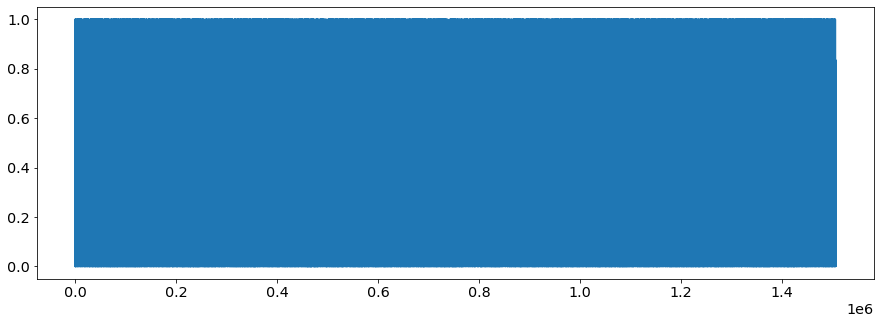

In [294]:
plt.plot(logtop.flatten())

In [295]:
np.count_nonzero(logtop.flatten())

1501830

In [296]:
np.average(flattop)

0.009678537215076973

In [297]:
# g = pd.DataFrame(goldIm)
# g.to_csv("Dream5_gold_r_t.csv")

In [298]:
#1506340

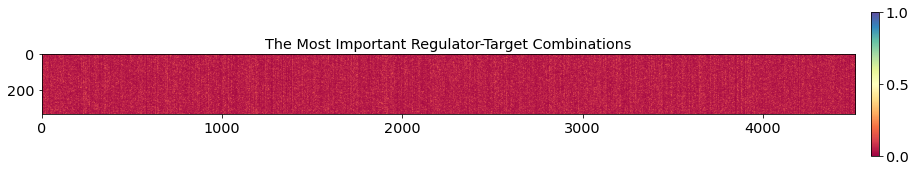

In [299]:
u = plt.imshow(logtop, cmap = 'Spectral');
plt.colorbar(u ,fraction=0.0086, pad=0.02);
plt.title("The Most Important Regulator-Target Combinations");

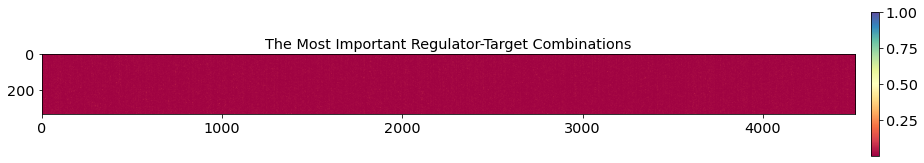

In [300]:
u = plt.imshow(flattop, cmap = 'Spectral');
plt.colorbar(u ,fraction=0.0086, pad=0.02);
plt.title("The Most Important Regulator-Target Combinations");

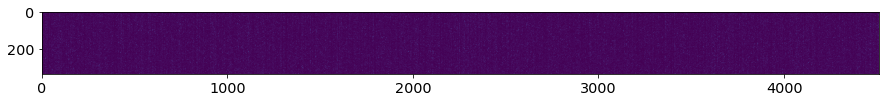

In [301]:
plt.imshow(pdf)

In [302]:
topID = np.array(np.unravel_index(np.argsort(top, axis=None), top.shape))
topID = np.flip(topID, axis=1)
topID[0] = parent_idx[topID[0]]
topID = topID.T
topID

array([[ 286,  294],
       [  92, 2721],
       [  21, 1622],
       ...,
       [ 142,  388],
       [  58, 2756],
       [  61,   87]], dtype=int64)

In [303]:
topR_T = pd.DataFrame(topID)
# topR_T.to_csv(r"Dream5_Top_reg_target_decendingOrder_firstColIsRegulator.csv")

In [304]:
best = np.zeros(NUM_PARENTS)
for i in range(NUM_PARENTS):
    best[i] = np.sum(top[i])


In [305]:
np.argmax(best)

249

Text(0, 0.5, 'Sum of Regulator-AllSubstrate Importances')

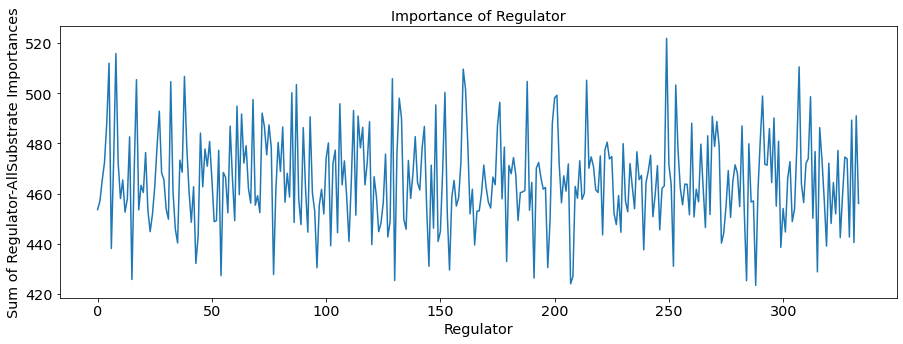

In [306]:
x = np.arange(0,NUM_PARENTS, dtype=int)
plt.plot(x, best); 
plt.title("Importance of Regulator")
plt.xlabel("Regulator")
plt.ylabel("Sum of Regulator-AllSubstrate Importances")

# Gold Standard Comparison

In [307]:
gold = pd.read_csv("DREAM5_NetworkInference_GoldStandard_Network3.csv", header=None)
gold.head(5)

,0,1,2
0,G92,G2,1
1,G232,G3,1
2,G55,G4,1
3,G56,G4,1
4,G268,G4,1


In [308]:
def keep_numeric(df):

    return df.applymap(lambda x: ''.join(filter(str.isdigit, str(x))) if isinstance(x, (int,float)) else ''.join(filter(str.isdigit, x)) )
gold = keep_numeric(gold)



In [309]:
gold.head(5)

,0,1,2
0,92,2,1
1,232,3,1
2,55,4,1
3,56,4,1
4,268,4,1


In [312]:
goldnp.shape[0]

152280

In [315]:
pdf[54][3]

1.0

In [316]:
mag[231][2]

0.03508962

In [317]:
goldnp

array([[  91,    1,    1],
       [ 231,    2,    1],
       [  54,    3,    1],
       ...,
       [ 331, 4504,    0],
       [ 332, 4504,    0],
       [ 333, 4504,    0]])

In [318]:
goldIm = np.zeros(shape=(NUM_PARENTS,NUM_TARGETS))

for g in goldnp:
    reg = g[0]
    tar = g[1]
    connection = g[2]
    goldIm[reg][tar] = connection

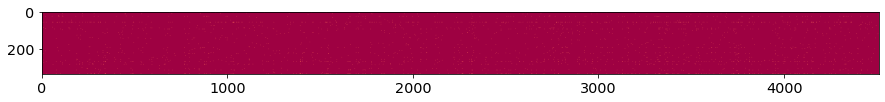

In [319]:
plt.imshow(goldIm, cmap='Spectral')

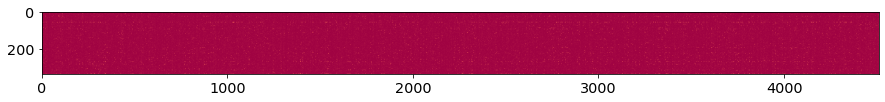

In [320]:
plt.imshow(np.abs(goldIm - flattop), cmap='Spectral');

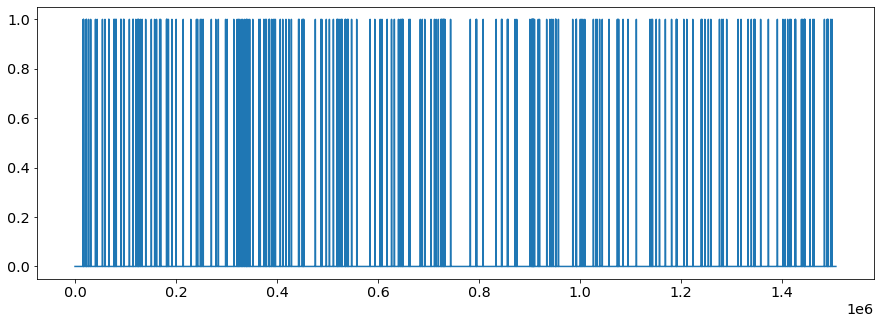

In [333]:
plt.plot(np.rint( flattop.flatten()))

In [321]:
np.square(goldIm - flattop)

array([[1.25607681e-05, 2.23247677e-05, 3.74522082e-06, ...,
        4.29459234e-05, 3.53646066e-06, 5.29299010e-07],
       [3.14050528e-06, 1.12779418e-06, 5.33183241e-05, ...,
        1.63650867e-05, 4.88577576e-03, 1.15979513e-03],
       [7.33547643e-06, 7.15633600e-06, 9.27775635e-06, ...,
        2.00120547e-05, 2.57555896e-02, 7.77258162e-06],
       ...,
       [3.75264817e-06, 6.89157035e-06, 9.87665679e-06, ...,
        6.03430675e-05, 3.32280097e-06, 2.48162428e-05],
       [2.25564208e-05, 1.37679981e-05, 8.31157412e-03, ...,
        2.28716620e-05, 3.15743226e-06, 5.42051179e-04],
       [1.34720416e-05, 8.61823997e-06, 1.67422805e-03, ...,
        8.11649393e-06, 4.25806271e-06, 3.57020738e-06]])

In [322]:
sum(np.abs(goldIm - flattop).flatten())

16603.373244098868

In [323]:
mag.reshape((-1,1)).shape

(1506340, 1)

In [324]:
magX = StandardScaler().fit_transform(mag.reshape((-1,1)))
magX = MinMaxScaler().fit_transform(magX.reshape((-1,1)))

In [325]:
magX

array([[0.2066841 ],
       [0.27563196],
       [0.11274081],
       ...,
       [0.1660922 ],
       [0.12022948],
       [0.11006894]], dtype=float32)

In [326]:
1 - np.sum(np.square(goldIm - flattop).flatten())/(NUM_PARENTS*NUM_TARGETS)

0.9979639472869958

In [327]:
roc_auc_score(goldIm.flatten(), magX.flatten())

0.4987495381359466

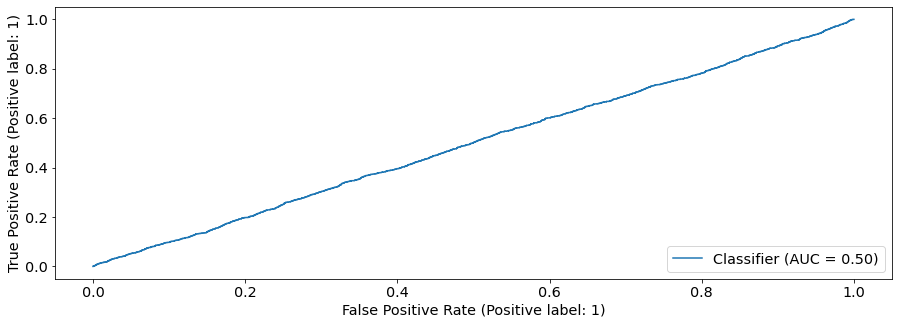

In [328]:
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(goldIm.flatten(), flattop.flatten());


In [329]:
from sklearn.metrics import log_loss
log_loss(y_true := goldIm.flatten(), y_pred := flattop.flatten())

0.017634753439846714

In [332]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_true, np.rint( flattop.flatten()))

array([[1504031,     243],
       [   2066,       0]], dtype=int64)

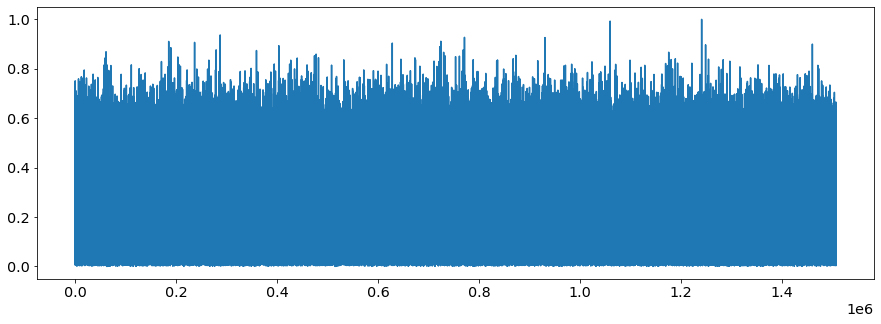

In [252]:
plt.plot(magX.squeeze())

In [334]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_true, np.rint( flattop.flatten()))

0.4999192301402537

<AxesSubplot:>

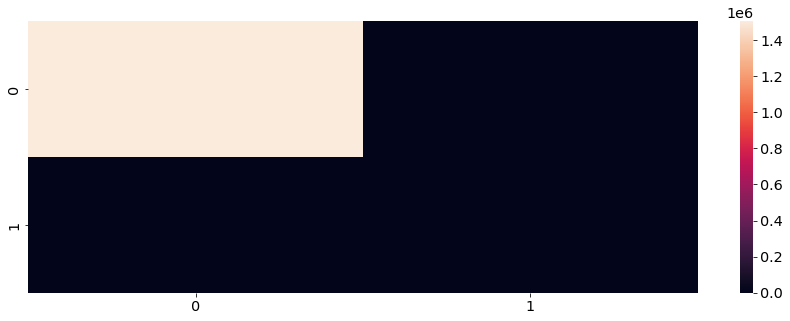

In [219]:
import seaborn as sn
sn.heatmap(confusion_matrix(y_true, magX.squeeze()))

In [213]:
magX.shape

(1506340, 1)

In [214]:
y_true.shape

(1506340,)

In [216]:
np.sum(np.square(y_true, magX.squeeze()))

2066.0

In [149]:
idx = np.flip(np.argsort(best))
idx

array([134,  54, 216, 268, 317, 188, 139, 121,  38, 269, 260, 236, 249,
       129, 264,  73, 112, 308,   8, 292, 169, 102, 182, 310,  10, 227,
       277, 224, 220, 148,  86,  29, 283, 270, 234, 186, 141, 101, 155,
       156, 130, 237,  49,  14, 151, 285, 215, 204, 165, 158, 312, 309,
       104, 230, 126, 144,  39, 319, 231, 299,  31,   2,   3, 229, 290,
       133, 103, 184, 167, 146, 173,  68,  81, 248, 219, 271, 223,  16,
       135, 180, 296, 178,  94,  57, 320, 174,   7, 213, 122, 183, 332,
        98, 147, 261, 321,  43, 196, 194, 140, 195,  67, 222, 300,  45,
        65,  88, 254, 252,  55, 110, 207,  19,  17,  58, 154,  97,  52,
        89, 210, 179,   9, 127,  47,  44, 115, 302, 211, 315,  80,  35,
        93,  92, 273, 149,  11, 257, 132, 172, 232, 185, 253,  70, 306,
       197, 325, 163, 304, 245, 226, 203, 251,   0, 262,  64,   6, 218,
       274, 143, 241, 175, 164, 239, 313, 131, 305, 138, 171,  87, 235,
        69, 124, 298,   4, 187, 326,  34, 106, 161, 282,  36,  6

In [150]:
parent_idx[idx] 

array([134,  54, 216, 268, 317, 188, 139, 121,  38, 269, 260, 236, 249,
       129, 264,  73, 112, 308,   8, 292, 169, 102, 182, 310,  10, 227,
       277, 224, 220, 148,  86,  29, 283, 270, 234, 186, 141, 101, 155,
       156, 130, 237,  49,  14, 151, 285, 215, 204, 165, 158, 312, 309,
       104, 230, 126, 144,  39, 319, 231, 299,  31,   2,   3, 229, 290,
       133, 103, 184, 167, 146, 173,  68,  81, 248, 219, 271, 223,  16,
       135, 180, 296, 178,  94,  57, 320, 174,   7, 213, 122, 183, 332,
        98, 147, 261, 321,  43, 196, 194, 140, 195,  67, 222, 300,  45,
        65,  88, 254, 252,  55, 110, 207,  19,  17,  58, 154,  97,  52,
        89, 210, 179,   9, 127,  47,  44, 115, 302, 211, 315,  80,  35,
        93,  92, 273, 149,  11, 257, 132, 172, 232, 185, 253,  70, 306,
       197, 325, 163, 304, 245, 226, 203, 251,   0, 262,  64,   6, 218,
       274, 143, 241, 175, 164, 239, 313, 131, 305, 138, 171,  87, 235,
        69, 124, 298,   4, 187, 326,  34, 106, 161, 282,  36,  6

In [152]:
parent_idx

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [151]:
np.unique(can).size

105837

# Inference on Petal Len

In [ ]:
petal = pd.read_excel(data_path_petal)

In [ ]:
petal_train = petal[petal["Line"] == "WT"]
petal_train = petal_train.drop(columns=['Line', 'ID', "Treatment"])
petal_train.head(12)
petal_train = petal_train.groupby(['Plate']).mean()
petal_train.head()
petal_train = petal_train.to_numpy()
print(petal_train.shape)
scaler1 = StandardScaler()
scaler1.fit(petal_train)
petal_train = scaler1.transform(petal_train)
mm = MinMaxScaler()
mm.fit(petal_train)
petal_train = mm.transform(petal_train)
petal_train

In [ ]:
petal_test = petal[petal["Line"] != "WT"]
petal_test = petal_test.drop(columns=['Line', 'ID', "Treatment"])
petal_test = petal_test.groupby(['Plate']).mean()
petal_test.head()
petal_test = petal_test.to_numpy()
print(petal_test.shape)
petal_test = scaler1.transform(petal_test)
petal_test = mm.transform(petal_test)
petal_test

In [ ]:
experiment1.shape
testCandidate.shape

In [ ]:
densePredictor = modelDense2(superParent, regulator_gene_matrix, NUM_TARGETS, 6, NUM_TARGETS, 22)
densePredictor.compile(optimizer='adam', loss=ignore_noParent_MSE)
densePredictor.fit(ecoli_Intensities, ecoli_Intensities,validation_data=(experiment1, experiment1),  epochs=100,  verbose=1)
test = densePredictor(testCandidate) #, verbose = 0)
loss = ignore_noParent_MSE(testCandidate, test)
print(loss)

In [ ]:
rgm = superParent
time_steps = 6
num_kinase_regulators = NUM_TARGETS
num_hidden_units = 22

inp = Input(shape=(time_steps, num_kinase_regulators))
x = DAE_Encoder_MASK(rgm, regulator_gene_matrix, NUM_TARGETS, NUM_TARGETS)(inp)
enc = denseencoder2(x, inp, num_hidden_units)
denseP = tf.keras.Model(inputs=inp, outputs=enc)
#set the weights of the encoder to the weights of auto encoder
dw = densePredictor.get_weights()
enc_w = dw[0:5]
denseP.set_weights(enc_w)
#add a dense layer  because we are ouputing 1 number
l = Dense(32, activation = 'swish', use_bias=True, kernel_regularizer='l1_l2')(denseP.layers[-1].output)
l = Dense(1, activation = 'linear', use_bias = True)(l)
denseP = tf.keras.Model(denseP.inputs, l)
#denseP.summary()

In [ ]:
bp = np.concatenate([experiment1, experiment1, experiment1, experiment1])
bp.shape
#bigexperiment1.shape

In [ ]:
a = petal_train[0]
b = petal_train[1]
c = petal_train[2]
d = petal_train[3]

petal_train1 = np.array([a,a,a,a, b,b,b,b, c,c,c,c, d,d,d,d]) #does this make sense? we are training network to predict .5
petal_train1.shape

In [ ]:
denseP.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
denseP.fit(experiment1, petal_train, epochs=500, verbose = 1)

In [ ]:
testCandidate.shape

In [ ]:
denseP(experiment1) #experiment1 is part of the training set.

In [ ]:
petal_train

In [ ]:
print(denseP(testCandidate)) #model output

In [ ]:
petal_test #true label

In [ ]:
petal_train

In [ ]:
denseP.evaluate(testCandidate, petal_test) #eval gave 1.3999 before

# Junk

# Load the test set and the synthetic dataset:


In [ ]:
def loadTestSet(test_path):
    testFiles = []
    for np_name in glob(os.path.join(data_path_testSet,'*.np[yz]')):
        k = np.load(os.path.join(data_path_testSet,np_name))
        testFiles.append(k)
#         print(np_name)
#         print(k.shape)
    return np.array(testFiles)

In [ ]:
def read_files(data_path):

    #genes_intensities_data_matrix = pd.read_csv(file_path_intensities, index_col = 0)
    #print(os.listdir(data_path))
    replicate_files = os.listdir(data_path)
    #print('replicate files:',replicate_files)
    replicates = []
    # i = 0
    for file in replicate_files:
        
        try:
            #print('file name:',file)
            #print('value of i:',i)
            genes_intensities_data_matrix = pd.read_csv(os.path.join(data_path , file), index_col = 0, on_bad_lines='skip')
            #print('genes_intensities_data_matrix:',  genes_intensities_data_matrix.head())
            replicates.append(np.array(genes_intensities_data_matrix.values, dtype = float))
            # i+=1
        except PermissionError:
            print("Not a CSV: ", os.path.join(data_path , file))
        
    genes_intensities_data_matrix = genes_intensities_data_matrix.values
    rgm = np.loadtxt(matrix_path)
    rep = np.array(replicates).astype(np.float32)
    
    return rep, rgm.astype(np.float32)

In [ ]:
ecoli_Intensities, regulator_gene_matrix= read_files(data_path_syn)
matrix = regulator_gene_matrix
replicates = ecoli_Intensities

In [ ]:
matrix.shape

In [ ]:
replicates.shape

In [ ]:
plt.imshow(matrix)

In [ ]:
d = np.zeros(shape = (3,6,8))
id = np.unravel_index(3*6*8 - 1, shape = d.shape)
d[id] = 1
plt.imshow(d[2])

In [ ]:
testCandidate[0][ : , parentIndex]

In [ ]:
print(outSyn.shape)
print(testCandidate.shape)
syntheticLoss = ignore_noParent_MSE(np.array([testCandidate[0]]), np.array([outSyn[0]]) )
syntheticLoss

In [ ]:
dd

In [ ]:
plt.plot(change[0][22])
plt.xlabel("epoch")
plt.ylabel("change in weight")

In [ ]:
plt.plot(lossMatrix)
plt.xlabel("epochs")
plt.ylabel("MSE")

In [ ]:
print(change.shape, lossMatrix.shape)

In [ ]:
d = np.diff(change[0][22])
plt.plot(d)
d.shape

In [ ]:
change[0][0].flatten()

In [ ]:
top_pr.shape

In [ ]:
plt.plot(d[0])

In [ ]:

# def compute_tresh(change, stop = 0.05):
#     diffs = []
#     for parent in range(len(change)):
#         for child in range(len(change[0])):
#             diffs.append(np.diff(change[parent][child]))
#     inflection = []


#     try:
#         for d in diffs:
#             print(np.argwhere(np.abs(d) < stop))
#             inflection.append(np.min(np.argwhere(np.abs(d) < stop))) #return where the second derivative is first 0. 

#     except ValueError:
#         print("Stop value ", stop, " is too high, trying stop = ", stop + 0.05)
#         # s = stop + 0.05
#         # return compute_tresh(change, stop = s)
        

#     return np.average(inflection)
        
# d = compute_tresh(change)
# d.shape

In [ ]:
#np.save("mse3.npy", avgMSE) #mse2/3 is with -1 fix

In [ ]:
#https://www.sciencedirect.com/science/article/pii/S0925231220314570?casa_token=lcEJANqO0JwAAAAA:uL3DGUZctPUZz_sPz1K1i2klMtb83TyKnc9CI3_N-uSOaM7VHL8GhM0jCGYfo25NmpDQQ9Cvlw

In [ ]:
rshp = Flatten()(looseParent.layers[-1].output)

modelTemp = tf.keras.Model(inputs=looseParent.input, outputs = [rshp])
modelTemp.summary()
type(modelTemp)
explainer = shap.DeepExplainer(modelTemp, syntheticDataTrain)
#shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough #this solves the "shap_ADDV2" problem but another one will appear
#shap.explainers._deep.deep_tf.op_handlers["FusedBatchNormV3"] = shap.explainers._deep.deep_tf.passthrough #this solves the next problem which allows you to run the DeepExplainer.

shap_values = explainer.shap_values(testCandidate[0:1])
def f(x):
    return modelTemp.predict(x)

print(f(testCandidate))
explainer = shap.KernelExplainer(f , testCandidate[0:1], link="logit") #svm.predict_proba, X_train, link="logit")
shap_values = explainer.shap_values(testCandidate[0:1], nsamples=100)
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)
e = shap.GradientExplainer(
    (model.layers[7].input, model.layers[-1].output),
    map2layer(X, 7),
    local_smoothing=0 # std dev of smoothing noise
)
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import keras.backend as K
import numpy as np
import json
import shap

# load pre-trained model and choose two images to explain
model = VGG16(weights='imagenet', include_top=True)
X,y = shap.datasets.imagenet50()
to_explain = X[[39,41]]

# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

# explain how the input to the 7th layer of the model explains the top two classes
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)
e = shap.GradientExplainer(
    (model.layers[7].input, model.layers[-1].output),
    map2layer(X, 7),
    local_smoothing=0 # std dev of smoothing noise
)
shap_values,indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=2)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap.image_plot(shap_values, to_explain, index_names)

In [ ]:
type(enc_dec_Synthetic)

In [ ]:
a = [1,2,3]
b = [5,6]
u = tf.concat([a,b], axis = 0)
u

In [ ]:
newConnections = superParent - regulator_gene_matrix

In [ ]:
plt.imshow(newConnections)

In [ ]:
# nC = []
# for i in range(len(newConnections[0])):
#     for j in range(len(newConnections[1])):
#         if newConnections[i][j] > 0:
#             nC.append([i,j])
# nC = np.array(nC)
# nC = pd.DataFrame(nC)
# nC.to_csv("new_connections_in_superParents.csv")

In [ ]:
###Code for testing loss function
# print(outSyn.shape)
# print(testCandidate.shape)
# syntheticLoss = ignore_noParent_MSE(np.array([testCandidate[0]]), np.array([outSyn[0]]) )
# syntheticLoss

# Synthetic Dataset Auto Encoder
Autoencoder has not been trained on synthetic version of experiement 1. We test on the original experiment 1. 

In [ ]:
enc_dec_Synthetic.compile(optimizer='adam', loss=ignore_noParent_MSE)

In [ ]:
# enc_dec_Synthetic.compile(optimizer='adam',loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [ ]:
syntheticDataTrain = ecoli_Intensities[1:]

In [ ]:
enc_dec_Synthetic.fit(syntheticDataTrain,syntheticDataTrain,epochs=1000)

In [ ]:
test = enc_dec_Synthetic(testCandidate) #, verbose = 0)
loss = ignore_noParent_MSE(testCandidate, test)
loss

In [ ]:
w = enc_dec_Synthetic.get_weights()

In [ ]:
plt.imshow(w[0], cmap = "hot", vmin=0,vmax=0.02)

In [ ]:
#we do not need to use this function for the testset
def getCSVs(data_path_head):
    PATH = data_path_head
    EXT = "*.csv"
    all_csv_files = [file
                     for path, subdir, files in os.walk(PATH)
                     for file in glob(os.path.join(path, EXT))]
    actual = []
    for p in all_csv_files:
        actual.append(pd.read_csv(p, index_col = 0).to_numpy())
    return np.array(actual)
    
experiment1 = getCSVs(data_path_og_exp1)

In [ ]:
testCandidate = test.numpy().astype(np.float)

In [ ]:
testCandidate.dtype

In [ ]:
np.array([ecoli_Intensities[0]]).shape

In [ ]:
testCandidate[0].shape

In [ ]:
np.array([ecoli_Intensities[0]]).shape

In [ ]:
outSyn = enc_dec_Synthetic.predict(testCandidate)

In [ ]:
def mymagn(A, B):
    mse = (np.square(A - B)).mean(axis=None)
    return mse

In [ ]:
print(outSyn.shape)

In [ ]:
syntheticLoss = ignore_noParent_MSE(testCandidate, outSyn )
syntheticLoss

In [ ]:
(outSyn-testCandidate).shape

In [ ]:
#!pip3 install keras-visualizer
#!pip install pydot
#data_path_og_exp1 = data_path_testSet 
# !pip install pydot
# !pip install pydotplus
# !pip install graphviz

In [ ]:
# test = loadTestSet(data_path_testSet)
# testCandidate = test.astype(np.float)


In [ ]:
enc_dec_Synthetic = model(regulator_gene_matrix, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS) #we can just change the time steps to something higher

In [ ]:
enc_dec_Synthetic.summary()

# Interpolated dataset Auto Encoder
Once again, we do not train on any version of exp1

In [ ]:
def read_filesV2(data_path):
    '''
    *Changed*
    currently hardcoded for only one file. 
    change code a bit for reading multiple files.
    '''
    #genes_intensities_data_matrix = pd.read_csv(file_path_intensities, index_col = 0)
    #print(os.listdir(data_path))
    replicate_files = os.listdir(data_path)
    #print('replicate files:',replicate_files)
    replicates = []
    # i = 0
    for file in replicate_files:
        
        #print('file name:',file)
        #print('value of i:',i)
        genes_intensities_data_matrix = pd.read_csv(os.path.join(data_path , file), index_col = 0, on_bad_lines='skip')
        #print('genes_intensities_data_matrix:',  genes_intensities_data_matrix.head())
        replicates.append(genes_intensities_data_matrix.values)
        # i+=1
        
    genes_intensities_data_matrix = genes_intensities_data_matrix.values
    rgm = np.loadtxt(matrix_path)
    
    return np.asarray(replicates), rgm.astype(np.float32)

In [ ]:
interpolated_genes, _ = read_filesV2(data_path_inter)

In [ ]:
interpolated_genes.shape

In [ ]:
pd.DataFrame(interpolated_genes[2]).head(5)

In [ ]:
inter = []
for k in range(len(interpolated_genes)):
    #print(k)
    if k == 2 or k == 3 or k == 4:
        inter.append(np.reshape(interpolated_genes[k], (4,6,NUM_TARGETS)))
    else: 
        inter.append(np.reshape(interpolated_genes[k], (5,6,NUM_TARGETS)))
inter = np.vstack(inter)

In [ ]:
inter.shape

In [ ]:
ecoli_Intensities[1:].shape

In [ ]:
enc_dec_inter = model(regulator_gene_matrix, NUM_TARGETS, 6, NUM_TARGETS) 
enc_dec_inter.compile(optimizer='adam', loss=ignore_noParent_MSE)

In [ ]:
enc_dec_inter.fit(inter, inter,epochs=1000);

In [ ]:
outInter = enc_dec_inter.predict(testCandidate)
interpolationLoss = ignore_noParent_MSE(testCandidate, outInter)

In [ ]:
interpolationLoss #used to be 3.84 on broke ignore

In [ ]:
outInter.shape

In [ ]:
u = enc_dec_inter.history
u

# Comparisons between various outputs:

In [ ]:
u = plt.imshow(np.reshape((np.abs(outSyn)), (24,NUM_TARGETS)), cmap = "hot", vmin=0,vmax=1.0 );

In [ ]:
u = pd.DataFrame(outSyn[0])
u.head(10)

In [ ]:
u = pd.DataFrame(testCandidate[0])
u.head(10)

In [ ]:
plt.figure(figsize=(50, 50))
u = plt.imshow(np.reshape((np.abs(outSyn-outInter)), (24,NUM_TARGETS)), cmap = "hot")#, vmin=0,vmax=1.0 );
plt.title("Difference Between the Outputs of Both Autoencoders", fontsize = 40);
plt.xlabel("Phosphopeptide", fontsize = 30);
plt.ylabel("Times Concatenated", fontsize = 30);
plt.colorbar(u ,fraction=0.0046, pad=0.02);
#plt.savefig("DiffBetweenOut.png")

In [ ]:
plt.figure(figsize=(50, 50))
u = plt.imshow(np.reshape(np.abs(outInter-experiment1), (24,NUM_TARGETS)) , cmap = "hot") #, vmin=0,vmax=1.0 )
plt.title("Difference Between the Input and Output of the Autoencoder Trained on Interpolated Data", fontsize = 40);
plt.xlabel("Phosphopeptide", fontsize = 30)
plt.ylabel("Times Concatenated", fontsize = 30);
plt.colorbar(u ,fraction=0.0046, pad=0.02);
#plt.savefig("InterDiffImage.png")

In [ ]:
plt.figure(figsize=(50, 50))
u = plt.imshow(np.reshape(np.abs(outSyn-experiment1), (24,NUM_TARGETS)), cmap = "hot")#, vmin=0,vmax=1.0 )
plt.title("Difference Between the Input and Output of the Autoencoder Trained on Synthetic Data", fontsize = 40);
plt.xlabel("Phosphopeptide", fontsize = 30);
plt.ylabel("Times Concatenated", fontsize = 30);
plt.colorbar(u ,fraction=0.0046, pad=0.02);
#plt.savefig("SynDiffImage.png");

In [ ]:
parent_idx = parentIndex.numpy()
#print(parent_idx)
oSyn = (np.reshape((outSyn), (24,NUM_TARGETS)).T)[parent_idx]
oSyn = oSyn.T
oSyn.shape

exp1_col = (np.reshape((experiment1), (24,NUM_TARGETS)).T)[parent_idx]
exp1_col = exp1_col.T
print(exp1_col.shape)

u = plt.imshow(np.abs(oSyn - exp1_col), cmap = 'hot') #TODO use TF loss function instead of difference.
ddff = oSyn-exp1_col
plt.colorbar(u)
plt.title("Difference Between the Input and Output of the Autoencoder Trained on Synthetic Data. Only parents.");

In [ ]:
pd.DataFrame(oSyn).head(24)

In [ ]:
pd.DataFrame(exp1_col).head(24)


In [ ]:
pd.DataFrame(ddff).head(24)


In [ ]:
# np.save("interpolated_v2.npy", inter) #the interpolated dataset
# np.save("synthetic_v2.npy", ecoli_Intensities[1:]) # the synthetic dataset
# np.save("synOut_v2.npy", outSyn) #the output of the encoder trained on synthetic data with the input being exp1
# np.save("interOut_v2.npy", outInter) #the output of the encoder trained on interpolated data with the input being exp1